In [1]:
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D

import multiprocessing as mp
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import scipy as sp
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
import staintools
from staintools import stain_normalizer, LuminosityStandardizer
from staintools.preprocessing.input_validation import is_uint8_image

import sys
import time
import timeit

In [2]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

In [36]:
# User Input parameters
DATASET_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Test_Datasets')
# OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/19_08_20_testing')
OUTPUT_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Figure_Data/p53_vs_Path')
# TP53_PATH = DATASET_PATH.joinpath('test_dataset_10x_08_07_20_vahadane')
# PATH_PATH = DATASET_PATH.joinpath('test_dataset_path_10x_25_06_20_vahadane')
TP53_PATH = DATASET_PATH.joinpath('test_dataset_10x_29_07_20_vahadane_224px')
PATH_PATH = DATASET_PATH.joinpath('test_dataset_path_10x_04_08_20_vahadane_224px')
TP53_RESULTS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Results/figures_10x_23_07_20_strict_vahadane_224px/performance_matrix.csv')
# TP53_RESULTS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Results/figures_test_path_10x_04_08_20_vahadane_224px/performance_matrix.csv')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True
NN_TILE_SIZE = 224
CNN_BASE = 'vgg16'

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [4]:
tp53_results = pd.read_csv(TP53_RESULTS_PATH, index_col = 0)

In [5]:
tp53_results

,accuracy,balanced_accuracy,roc_auc,precision,recall,fscore
1792_T_9500_2,0.660371,0.491404,0.512317,0.475035,0.491404,0.391689
1798_T_9514_2,0.886972,0.822709,0.898208,0.832005,0.822709,0.821459
1919_T_10779_2,0.710389,0.728138,0.842399,0.806013,0.728138,0.709667
1932_T_9876_2,0.723807,0.673418,0.736557,0.680454,0.673418,0.670203
1939_T_9661_2,0.692351,0.703488,0.778226,0.704283,0.703488,0.703200
2011_T_9699_2,0.884956,0.901015,0.966503,0.902269,0.901015,0.900938
2019_T_9717_2,0.572757,0.615118,0.676037,0.622679,0.615118,0.609094
2023_T_9727_2,0.852056,0.867876,0.952475,0.871104,0.867876,0.867588
2036_T_9729_2,0.477452,0.430943,0.381341,0.429574,0.430943,0.428163
2038_T_11986_2,0.613288,0.627660,0.706628,0.631558,0.627660,0.624880


In [8]:
# Find the name of all TP53 cancer and non-cancer tiles
tp53_cancer_tiles = [x.stem for x in TP53_PATH.joinpath('tiles_10x/cancer').glob('*.jpeg')]
tp53_noncancer_tiles = [x.stem for x in TP53_PATH.joinpath('tiles_10x/non-cancer').glob('*.jpeg')]

verbose_print(f'TP53 : Found {len(tp53_cancer_tiles)} cancer tiles and {len(tp53_noncancer_tiles)} noncancer tiles')

TP53 : Found 17403 cancer tiles and 53010 noncancer tiles


In [9]:
# Find the name of all path cancer and non-cancer tiles
path_cancer_tiles = [x.stem for x in PATH_PATH.joinpath('tiles_10x/cancer').glob('*.jpeg')]
path_noncancer_tiles = [x.stem for x in PATH_PATH.joinpath('tiles_10x/non-cancer').glob('*.jpeg')]

verbose_print(f'Path : Found {len(path_cancer_tiles)} cancer tiles and {len(path_noncancer_tiles)} noncancer tiles')

Path : Found 24146 cancer tiles and 36760 noncancer tiles


In [12]:
# Create a dataframe with the tp53 tile names as index and TP53_Cancer label column
tp53_cancer_df = pd.DataFrame(True, index = tp53_cancer_tiles, columns = ['TP53_Cancer'])
tp53_noncancer_df = pd.DataFrame(False, index = tp53_noncancer_tiles, columns = ['TP53_Cancer'])
tp53_df = pd.concat([tp53_cancer_df, tp53_noncancer_df], axis = 0)

In [13]:
# Create a dataframe with the path tile names as index and Path_Cancer label column
path_cancer_df = pd.DataFrame(True, index = path_cancer_tiles, columns = ['Path_Cancer'])
path_noncancer_df = pd.DataFrame(False, index = path_noncancer_tiles, columns = ['Path_Cancer'])
path_df = pd.concat([path_cancer_df, path_noncancer_df], axis = 0)

In [14]:
# Combined the tp53 and path dataframes such that only tile names are retained
combined_df = pd.concat([tp53_df, path_df], axis=1, join='inner')
combined_df.head()

,TP53_Cancer,Path_Cancer
2038_T_11986_2_62_71,True,False
1798_T_9514_2_57_111,True,False
1939_T_9661_2_49_89,True,True
1939_T_9661_2_63_105,True,True
232_T_13230_2_15_40,True,False


In [15]:
excluded_tiles = len(tp53_df) + len(path_df) - 2 * len(combined_df)
verbose_print(f'{len(combined_df)} tiles were in both datasets, {excluded_tiles} tiles were not')

48454 tiles were in both datasets, 34411 tiles were not


In [16]:
tile_name_split = [x.split('_') for x in combined_df.index.values]
tile_locations = [f'{x[-2]}_{x[-1]}' for x in tile_name_split]
slide_names = [f'{x[0]}_{x[1]}_{x[2]}_{x[3]}' for x in tile_name_split]
combined_df['Location'] = tile_locations
combined_df['Slide'] = slide_names
combined_df = combined_df.set_index('Slide')
# combined_df(index = [np.array(slide_names), np.array(tile_locations)])

In [17]:
# pd.MultiIndex.from_frame(combined_df, names = ('Slide', 'Location'))

In [18]:
slide_names_unique = combined_df.index.unique()
len(slide_names_unique)

13

In [19]:
def plot_ROC(fpr, tpr, roc_auc, out_path):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(out_path, dpi=180)
    plt.close()

In [20]:
# lst = [x for x in zip(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)]
# lst2 = np.random.shuffle(zip(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values))

In [21]:
# def balanced_accuracy_score(true, pred):
#     repetitions = 10
#     accuracy = []
#     zipped = [x for x in zip(true, pred)]
#     while repetitions > 0:
#         np.random.shuffle(zipped)
#         true_values = [true for true, pred in zipped]
#         pred_values = [pred for true, pred in zipped]
#         if len(true) > len(pred): 
#             true_values = true_values[0: len(pred)]
#         else:
#             pred_values = pred_values[0 : len(true)]
#         accuracy.append(accuracy_score(true_values, pred_values))
#     return np.mean(np.array(accuracy))
        

In [22]:
performance_df = pd.DataFrame(columns = ['ACC', 'BACC', 'FPR', 'TPR', 'AUC'])
for name in slide_names_unique:
    slide_df = combined_df.loc[name]
    acc = accuracy_score(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    balanced_acc = balanced_accuracy_score(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    fpr, tpr, _ = roc_curve(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    roc_auc = auc(fpr, tpr)
    slide_performance = pd.Series({'ACC' : acc, 'BACC': balanced_acc, 'FPR' : fpr, 'TPR' : tpr, 'AUC' : roc_auc}, name = name)
    performance_df = performance_df.append(slide_performance)

performance_df = performance_df.sort_values(by=['AUC'], ascending = False)

acc = accuracy_score(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
balanced_acc = balanced_accuracy_score(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
fpr, tpr, _ = roc_curve(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
roc_auc = auc(fpr, tpr)
all_slide_performance = pd.Series({'ACC' : acc, 'BACC': balanced_acc, 'FPR' : fpr, 'TPR' : tpr, 'AUC' : roc_auc}, name = 'All Slides')
performance_df = performance_df.append(all_slide_performance)

In [23]:
performance_df

,ACC,BACC,FPR,TPR,AUC
2011_T_9699_2,0.919174,0.880310,"[0.0, 0.04173228346456693, 1.0]","[0.0, 0.8023529411764706, 1.0]",0.880310
2075_T_9787_2,0.873747,0.839126,"[0.0, 0.10004257130693912, 1.0]","[0.0, 0.7782945736434108, 1.0]",0.839126
232_T_13230_2,0.811083,0.802350,"[0.0, 0.13440643863179075, 1.0]","[0.0, 0.7391073326248672, 1.0]",0.802350
1919_T_10779_2,0.690548,0.799181,"[0.0, 0.0012091898428053204, 1.0]","[0.0, 0.5995717344753747, 1.0]",0.799181
2023_T_9727_2,0.913751,0.787771,"[0.0, 0.033153153153153155, 1.0]","[0.0, 0.6086956521739131, 1.0]",0.787771
1798_T_9514_2,0.914128,0.751280,"[0.0, 0.07071674971253354, 1.0]","[0.0, 0.5732758620689655, 1.0]",0.751280
2038_T_11986_2,0.564736,0.653689,"[0.0, 0.19583333333333333, 1.0]","[0.0, 0.5032119914346895, 1.0]",0.653689
1932_T_9876_2,0.656029,0.640174,"[0.0, 0.0912, 1.0]","[0.0, 0.3715486194477791, 1.0]",0.640174
2382_T_15360_2,0.813170,0.620304,"[0.0, 0.07598784194528875, 1.0]","[0.0, 0.31659574468085105, 1.0]",0.620304
1939_T_9661_2,0.593470,0.615909,"[0.0, 0.22111639982691475, 1.0]","[0.0, 0.45293538865201705, 1.0]",0.615909


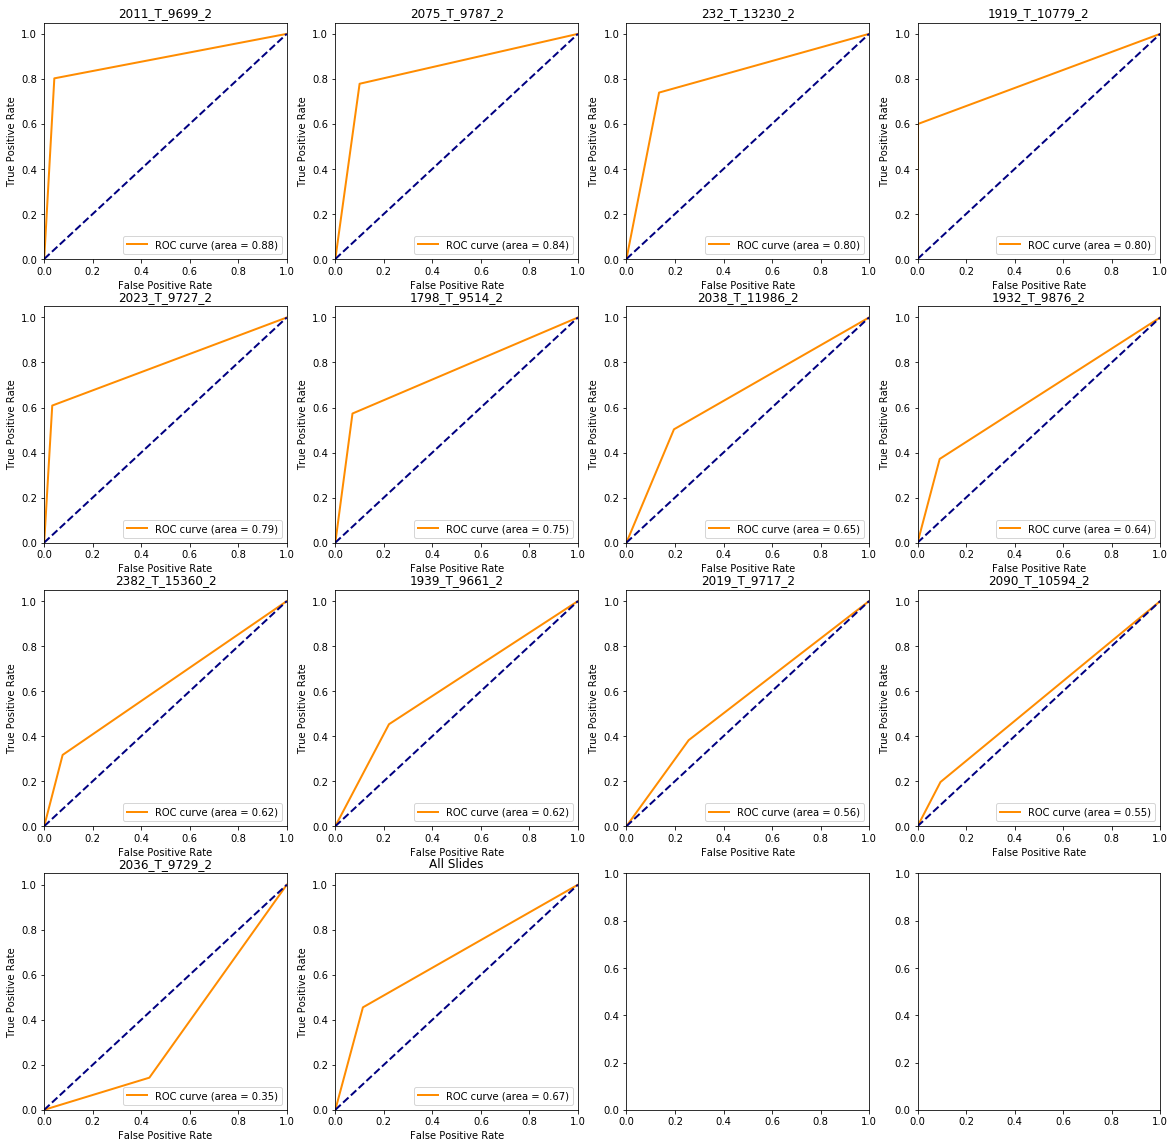

In [24]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (20,20))
lw = 2
for i, name in enumerate(performance_df.index):
    ax = axs[(i - i % 4) // 4, i % 4]
    fpr, tpr, roc_auc = performance_df.loc[name][['FPR', 'TPR', 'AUC']]
    ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title(name)

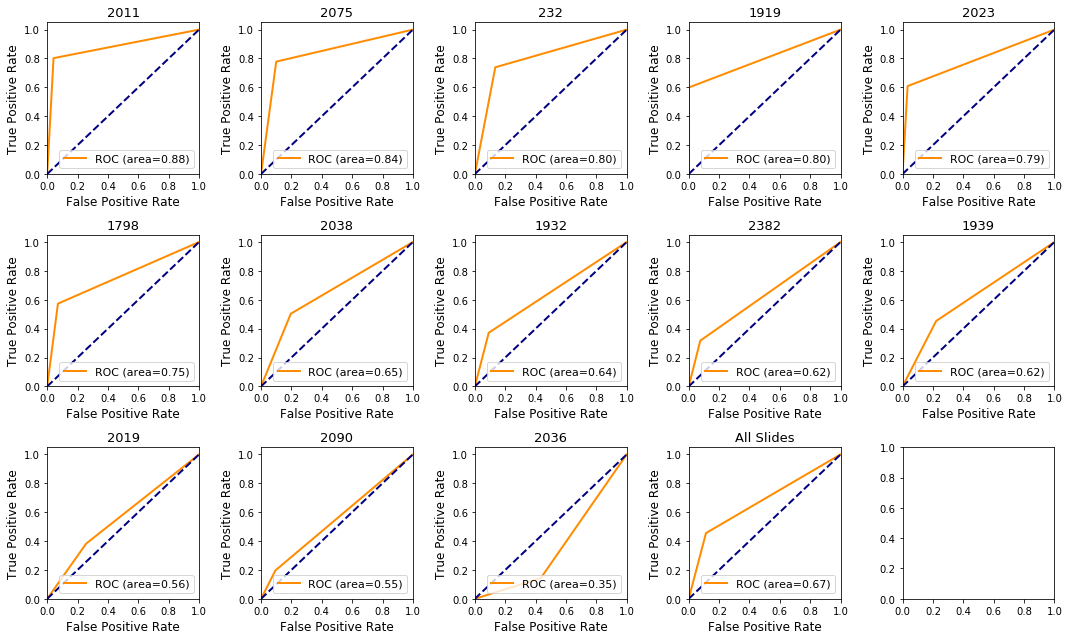

In [45]:
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (15,9))
# fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 16.67))
lw = 2
for i, name in enumerate(performance_df.index):
    ax = axs.ravel()[i]
    fpr, tpr, roc_auc = performance_df.loc[name][['FPR', 'TPR', 'AUC']]
    ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (area=%0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.legend(loc="lower right", fontsize=11)
    ax.set_title(name.split('_')[0], fontsize=13)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('p53_vs_path_roc_test_slides.svg'))

In [47]:
tp53_results_performance_df = pd.concat([tp53_results, performance_df], axis=1, join='inner')
tp53_results_performance_df

,accuracy,balanced_accuracy,roc_auc,precision,recall,fscore,ACC,BACC,FPR,TPR,AUC
1798_T_9514_2,0.886972,0.822709,0.898208,0.832005,0.822709,0.821459,0.914128,0.751280,"[0.0, 0.07071674971253354, 1.0]","[0.0, 0.5732758620689655, 1.0]",0.751280
1919_T_10779_2,0.710389,0.728138,0.842399,0.806013,0.728138,0.709667,0.690548,0.799181,"[0.0, 0.0012091898428053204, 1.0]","[0.0, 0.5995717344753747, 1.0]",0.799181
1932_T_9876_2,0.723807,0.673418,0.736557,0.680454,0.673418,0.670203,0.656029,0.640174,"[0.0, 0.0912, 1.0]","[0.0, 0.3715486194477791, 1.0]",0.640174
1939_T_9661_2,0.692351,0.703488,0.778226,0.704283,0.703488,0.703200,0.593470,0.615909,"[0.0, 0.22111639982691475, 1.0]","[0.0, 0.45293538865201705, 1.0]",0.615909
2011_T_9699_2,0.884956,0.901015,0.966503,0.902269,0.901015,0.900938,0.919174,0.880310,"[0.0, 0.04173228346456693, 1.0]","[0.0, 0.8023529411764706, 1.0]",0.880310
2019_T_9717_2,0.572757,0.615118,0.676037,0.622679,0.615118,0.609094,0.517434,0.562861,"[0.0, 0.2565217391304348, 1.0]","[0.0, 0.38224368499257055, 1.0]",0.562861
2023_T_9727_2,0.852056,0.867876,0.952475,0.871104,0.867876,0.867588,0.913751,0.787771,"[0.0, 0.033153153153153155, 1.0]","[0.0, 0.6086956521739131, 1.0]",0.787771
2036_T_9729_2,0.477452,0.430943,0.381341,0.429574,0.430943,0.428163,0.327487,0.354634,"[0.0, 0.43349753694581283, 1.0]","[0.0, 0.14276649746192893, 1.0]",0.354634
2038_T_11986_2,0.613288,0.627660,0.706628,0.631558,0.627660,0.624880,0.564736,0.653689,"[0.0, 0.19583333333333333, 1.0]","[0.0, 0.5032119914346895, 1.0]",0.653689
2075_T_9787_2,0.710087,0.729308,0.826080,0.729532,0.729308,0.729242,0.873747,0.839126,"[0.0, 0.10004257130693912, 1.0]","[0.0, 0.7782945736434108, 1.0]",0.839126


In [48]:
tp53_results_performance_df.sort_values(by = ['BACC'])

,accuracy,balanced_accuracy,roc_auc,precision,recall,fscore,ACC,BACC,FPR,TPR,AUC
2036_T_9729_2,0.477452,0.430943,0.381341,0.429574,0.430943,0.428163,0.327487,0.354634,"[0.0, 0.43349753694581283, 1.0]","[0.0, 0.14276649746192893, 1.0]",0.354634
2090_T_10594_2,0.481310,0.563000,0.611940,0.565359,0.563000,0.559020,0.553463,0.550893,"[0.0, 0.09436133486766399, 1.0]","[0.0, 0.19614711033274956, 1.0]",0.550893
2019_T_9717_2,0.572757,0.615118,0.676037,0.622679,0.615118,0.609094,0.517434,0.562861,"[0.0, 0.2565217391304348, 1.0]","[0.0, 0.38224368499257055, 1.0]",0.562861
1939_T_9661_2,0.692351,0.703488,0.778226,0.704283,0.703488,0.703200,0.593470,0.615909,"[0.0, 0.22111639982691475, 1.0]","[0.0, 0.45293538865201705, 1.0]",0.615909
2382_T_15360_2,0.849511,0.706606,0.772819,0.741375,0.706606,0.695646,0.813170,0.620304,"[0.0, 0.07598784194528875, 1.0]","[0.0, 0.31659574468085105, 1.0]",0.620304
1932_T_9876_2,0.723807,0.673418,0.736557,0.680454,0.673418,0.670203,0.656029,0.640174,"[0.0, 0.0912, 1.0]","[0.0, 0.3715486194477791, 1.0]",0.640174
2038_T_11986_2,0.613288,0.627660,0.706628,0.631558,0.627660,0.624880,0.564736,0.653689,"[0.0, 0.19583333333333333, 1.0]","[0.0, 0.5032119914346895, 1.0]",0.653689
1798_T_9514_2,0.886972,0.822709,0.898208,0.832005,0.822709,0.821459,0.914128,0.751280,"[0.0, 0.07071674971253354, 1.0]","[0.0, 0.5732758620689655, 1.0]",0.751280
2023_T_9727_2,0.852056,0.867876,0.952475,0.871104,0.867876,0.867588,0.913751,0.787771,"[0.0, 0.033153153153153155, 1.0]","[0.0, 0.6086956521739131, 1.0]",0.787771
1919_T_10779_2,0.710389,0.728138,0.842399,0.806013,0.728138,0.709667,0.690548,0.799181,"[0.0, 0.0012091898428053204, 1.0]","[0.0, 0.5995717344753747, 1.0]",0.799181


In [49]:
tp53_results_performance_df.columns

Index(['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall',
       'fscore', 'ACC', 'BACC', 'FPR', 'TPR', 'AUC'],
      dtype='object')

In [50]:
columns_dict = {'accuracy':'Accuracy', 'balanced_accuracy':'Balanced Accuracy', 'roc_auc':'ROC AUC' 
                , 'precision':'Precision', 'recall':'Recall', 'fscore':'F-score'}

In [51]:
columns_dict['accuracy']

'Accuracy'

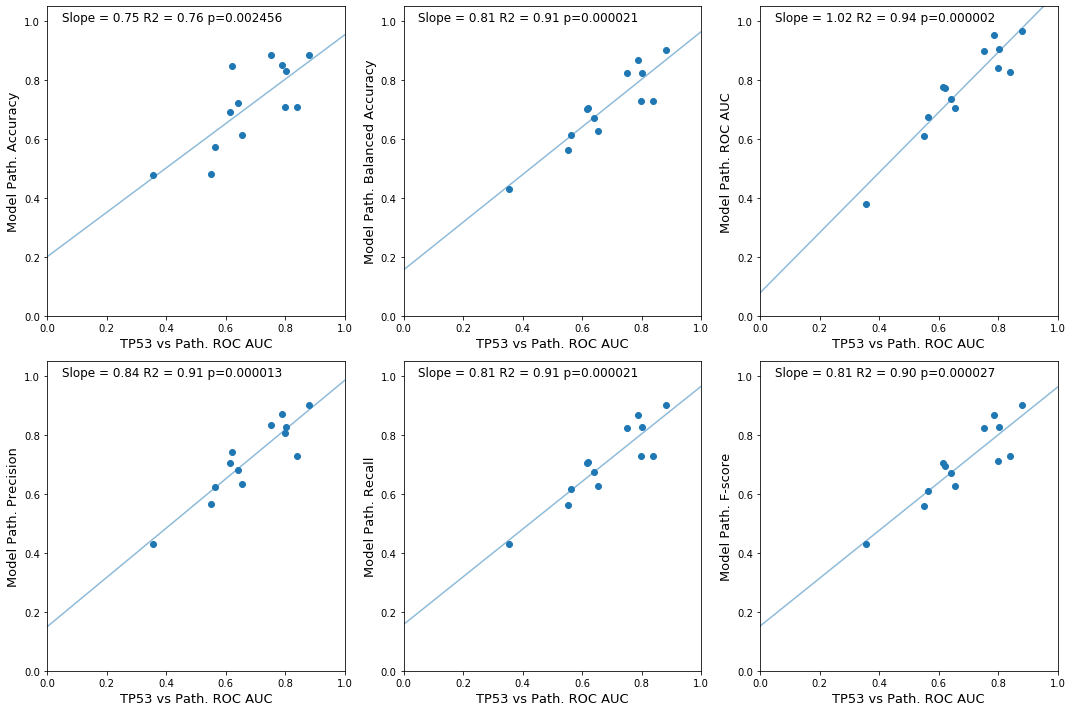

In [52]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
columns = ['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'fscore']
x_values = tp53_results_performance_df['AUC'].values
for i, column in enumerate(columns):
    ax = axs.ravel()[i]
    y_values = tp53_results_performance_df[column].values
    ax.scatter(x_values, y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50), alpha = 0.5)
    ax.text(0.05 , 1.0 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f} p={linreg.pvalue :.6f}'
           , fontsize = 12)
    ax.set_xlabel('TP53 vs Path. ROC AUC', fontsize = 13)
    ax.set_ylabel(f'Model Path. {columns_dict[column]}', fontsize=13)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.05)
fig.tight_layout()

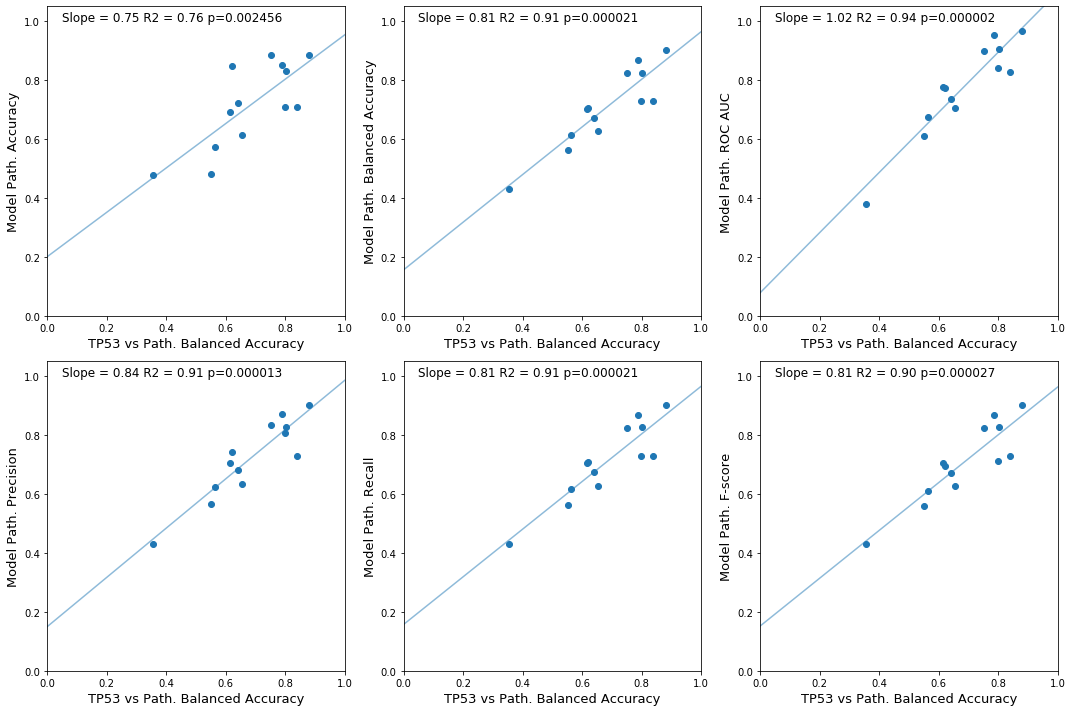

In [53]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
columns = ['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'fscore']
x_values = tp53_results_performance_df['BACC'].values
for i, column in enumerate(columns):
    ax = axs.ravel()[i]
    y_values = tp53_results_performance_df[column].values
    ax.scatter(x_values, y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50), alpha = 0.5)
    ax.text(0.05 , 1.0 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f} p={linreg.pvalue :.6f}'
           , fontsize = 12)
    ax.set_xlabel('TP53 vs Path. Balanced Accuracy', fontsize = 13)
    ax.set_ylabel(f'Model Path. {columns_dict[column]}', fontsize=13)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.05)
fig.tight_layout()

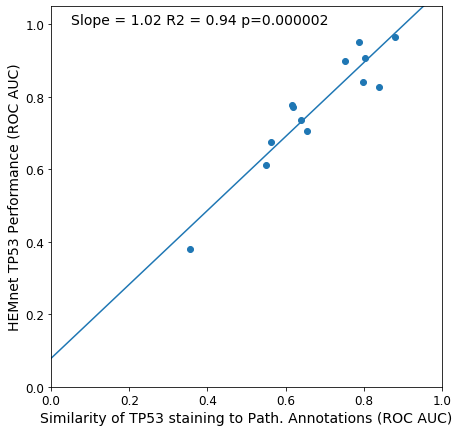

In [54]:
fig, ax = plt.subplots(figsize = (7,7))
y_values = tp53_results_performance_df['roc_auc'].values
x_values = tp53_results_performance_df['AUC'].values
ax.scatter(x_values, y_values)
linreg = sp.stats.linregress(x_values, y_values)
ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
ax.text(0.05 , 1.0 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f} p={linreg.pvalue :.6f}'
           , fontsize = 14)
ax.set_xlabel('Similarity of TP53 staining to Path. Annotations (ROC AUC)', fontsize=14)
ax.set_ylabel('HEMnet TP53 Performance (ROC AUC)', fontsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.tick_params(labelsize=12)

In [57]:
# Make a list of colors where each slide has a unique color
cmap = plt.cm.tab20(np.arange(len(bac_x_values)))
cmap

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.73333333, 0.47058824, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.59607843, 0.8745098 , 0.54117647, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [1.        , 0.59607843, 0.58823529, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.77254902, 0.69019608, 0.83529412, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ]])

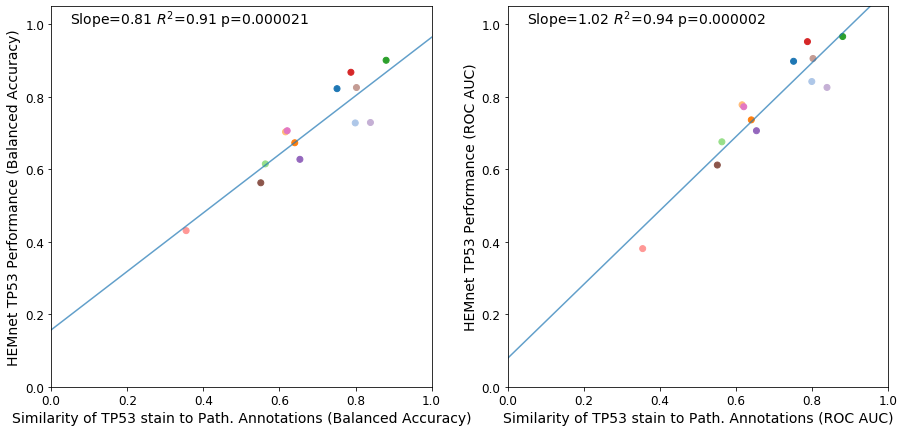

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,7))
bac_y_values = tp53_results_performance_df['balanced_accuracy'].values
bac_x_values = tp53_results_performance_df['BACC'].values
axs[0].scatter(bac_x_values, bac_y_values, c=cmap)
bac_linreg = sp.stats.linregress(bac_x_values, bac_y_values)
axs[0].plot(np.linspace(0,1, 50), bac_linreg.intercept + bac_linreg.slope * np.linspace(0,1, 50), alpha=0.7)
axs[0].text(0.05 , 1.0 , f'Slope={bac_linreg.slope :.2f} $R^2$={bac_linreg.rvalue :.2f} p={bac_linreg.pvalue :.6f}'
           , fontsize = 14)
axs[0].set_xlabel('Similarity of TP53 stain to Path. Annotations (Balanced Accuracy)', fontsize=14)
axs[0].set_ylabel('HEMnet TP53 Performance (Balanced Accuracy)', fontsize=14)

auc_y_values = tp53_results_performance_df['roc_auc'].values
auc_x_values = tp53_results_performance_df['AUC'].values
axs[1].scatter(auc_x_values, auc_y_values, c=cmap)
auc_linreg = sp.stats.linregress(auc_x_values, auc_y_values)
axs[1].plot(np.linspace(0,1, 50), auc_linreg.intercept + auc_linreg.slope * np.linspace(0,1, 50), alpha=0.7)
axs[1].text(0.05 , 1.0 , f'Slope={auc_linreg.slope :.2f} $R^2$={auc_linreg.rvalue :.2f} p={auc_linreg.pvalue :.6f}'
           , fontsize = 14)
axs[1].set_xlabel('Similarity of TP53 stain to Path. Annotations (ROC AUC)', fontsize=14)
axs[1].set_ylabel('HEMnet TP53 Performance (ROC AUC)', fontsize=14)
for ax in axs:
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.05)
    ax.tick_params(labelsize=12)
    
# verbose_save_fig(fig, OUTPUT_PATH.joinpath('TP53_vs_Path.jpeg'))

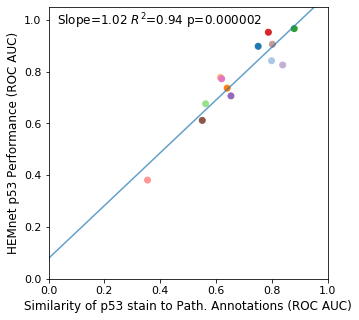

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
auc_y_values = tp53_results_performance_df['roc_auc'].values
auc_x_values = tp53_results_performance_df['AUC'].values
ax.scatter(auc_x_values, auc_y_values, c=cmap)
auc_linreg = sp.stats.linregress(auc_x_values, auc_y_values)
ax.plot(np.linspace(0,1, 50), auc_linreg.intercept + auc_linreg.slope * np.linspace(0,1, 50), alpha=0.7)
ax.text(0.03 , 0.98 , f'Slope={auc_linreg.slope :.2f} $R^2$={auc_linreg.rvalue :.2f} p={auc_linreg.pvalue :.6f}'
           , fontsize = 12)
ax.set_xlabel('Similarity of p53 stain to Path. Annotations (ROC AUC)', fontsize=12)
ax.set_ylabel('HEMnet p53 Performance (ROC AUC)', fontsize=12)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.tick_params(labelsize=11)
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('p53_vs_path_roc_auc_scatterplot.svg'))

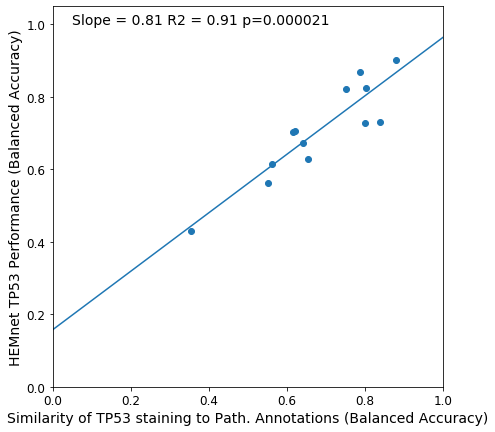

In [60]:
fig, ax = plt.subplots(figsize = (7,7))
y_values = tp53_results_performance_df['balanced_accuracy'].values
x_values = tp53_results_performance_df['BACC'].values
ax.scatter(x_values, y_values)
linreg = sp.stats.linregress(x_values, y_values)
ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
ax.text(0.05 , 1.0 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f} p={linreg.pvalue :.6f}'
           , fontsize = 14)
ax.set_xlabel('Similarity of TP53 staining to Path. Annotations (Balanced Accuracy)', fontsize=14)
ax.set_ylabel('HEMnet TP53 Performance (Balanced Accuracy)', fontsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.tick_params(labelsize=12)